# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Practical Component: Bias-Variance Analysis

## Regression Dataset Generation

Min: -0.9894500269756167
Max: 0.9519600511653384
Avg: -0.05908851444787669


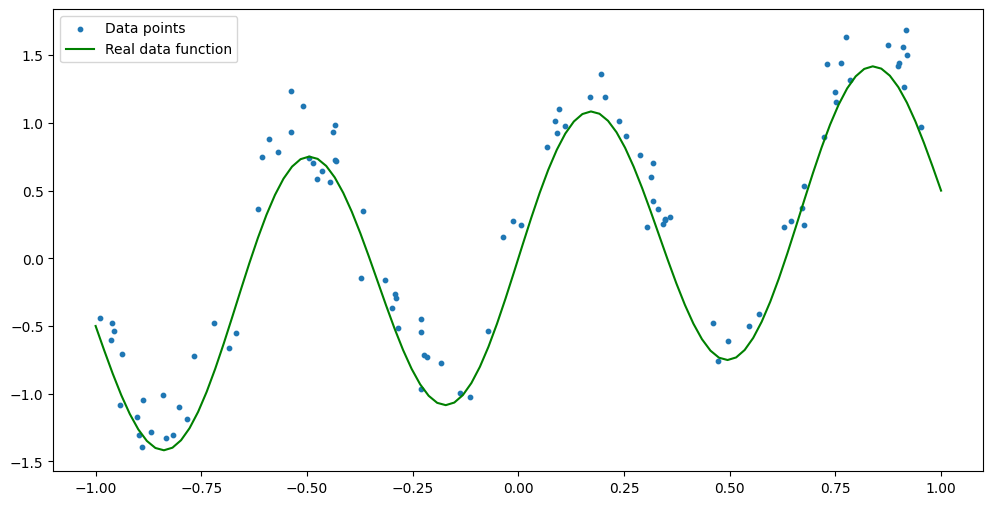

In [2]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Here I use make_regression just to generate randomly spaced values on the x axis
# The actual target values come later
X, _ = make_regression(n_samples=100, n_features=1, noise=0.0, random_state=42)

# Function to be modelled
# f(x) = sin(3πx) + x/2
def test_function(x):
    return np.sin(3.0 * np.pi * x) + x / 2

# Fixed seed, for testing
np.random.seed(42)

# Generate the dataset dataframe with the test function
# I also scale the X samples to be between -1 and 1
# Scaling based on tanh (I thought it was visually better than MinMaxScaler)
X_scaled = np.tanh(X.flatten())
df = pd.DataFrame(data={
    "regressors": X_scaled,
    "targets": test_function(X_scaled)
})

# Gaussian noise over target values
df["targets"] += np.random.normal(.2, .2, size=df["targets"].shape)

# Shuffling the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Min: {df['regressors'].min()}")
print(f"Max: {df['regressors'].max()}")
print(f"Avg: {df['regressors'].mean()}")

plt.figure(figsize=(12, 6))
interval = np.linspace(-1, 1, 100)
plt.scatter(df["regressors"], df["targets"], label="Data points", s=10)
plt.plot(interval, test_function(interval), color='green', label="Real data function")
plt.legend()
plt.show()

## Ridge Regression Model Training

In [3]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Train-Test split

# Model complexity that will be explored
# Lambdas -> Ridge complexity
# Knots -> Basis function complexity
lambdas = np.linspace(1, 1e-12, 6)
n_knots = np.linspace(3, 25, 6, dtype=np.int64)

# store the resulting models and train/test splits in this dictionary
results = {}

for lmb in lambdas:
  for knt in n_knots:
    train, test = train_test_split(df, test_size=0.25, random_state=np.int64(lmb*knt))
    pipeline = make_pipeline(
        SplineTransformer(degree=3, n_knots=knt),
        Ridge(alpha=lmb)
    )

    pipeline.fit(train.drop('targets', axis=1), train['targets'])
    results[(lmb, knt)] = (pipeline, train, test)

# Metrics for each lambda knot count combination
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

stats = pd.DataFrame(columns=["Lambda", "Knots", "Squared Bias", "Variance", "MSE"])

for (lmb, knt), (pipeline, train, test) in results.items():
  predictions = pipeline.predict(test.drop('targets', axis=1))
  mse = mean_squared_error(test['targets'], predictions)
  preds_mean = predictions.mean()
  bias_squared = np.mean((preds_mean - np.array(test['targets'])) ** 2)
  variance = np.var(predictions)
  stats.loc[len(stats)] = [lmb, knt, bias_squared, variance, mse]

# It's already possible to see that the highest bias is in the least complex model
# while the lowest bias and highest variance is in the most complex one (bottom)
stats

,Lambda,Knots,Squared Bias,Variance,MSE
0,1.000000e+00,3.0,0.781883,0.217153,0.519948
1,1.000000e+00,7.0,0.643617,0.204982,0.359421
2,1.000000e+00,11.0,0.557740,0.268426,0.133597
3,1.000000e+00,16.0,0.800830,0.423054,0.090164
4,1.000000e+00,20.0,0.726088,0.358671,0.112283
5,1.000000e+00,25.0,0.807650,0.402328,0.109692
6,8.000000e-01,3.0,0.600385,0.216926,0.498935
7,8.000000e-01,7.0,0.757068,0.372743,0.274962
8,8.000000e-01,11.0,0.626211,0.442386,0.078845
9,8.000000e-01,16.0,0.631916,0.383345,0.081627


## Bias-Variance Visualization

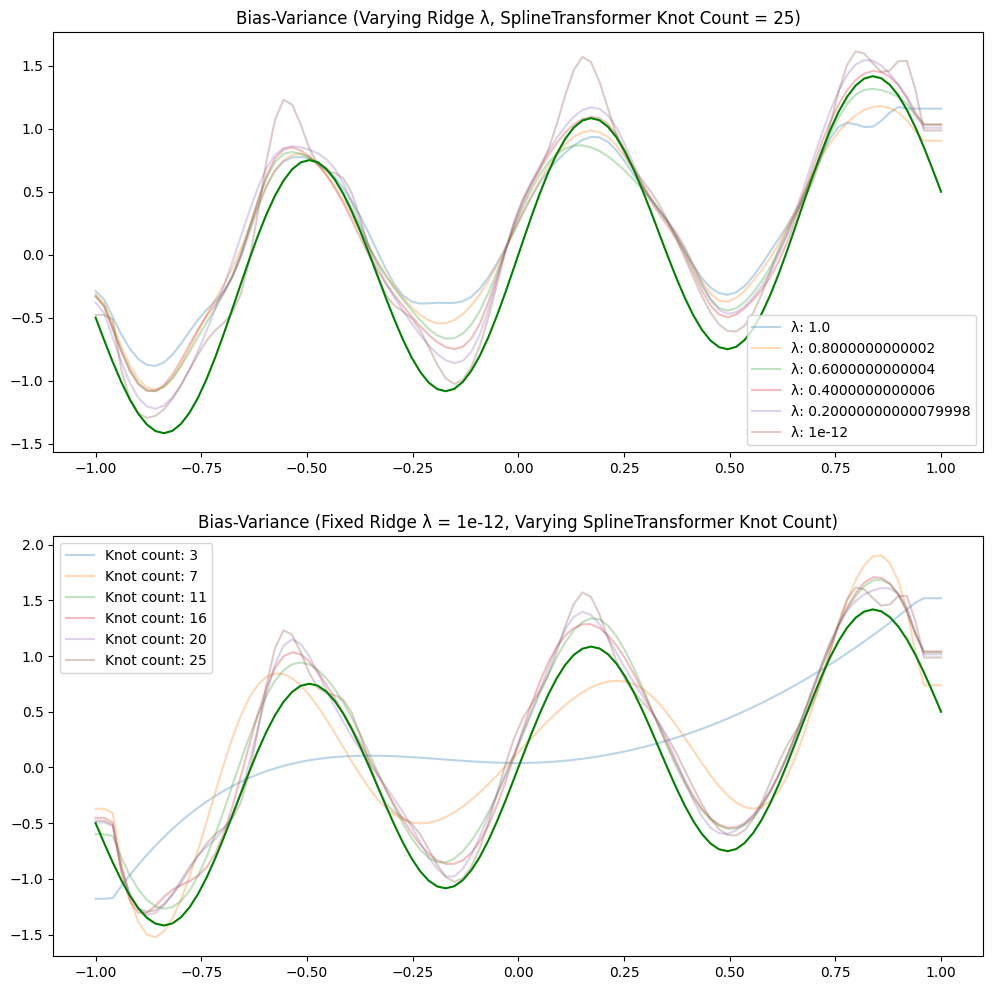

In [4]:
interval = np.linspace(-1, 1, 100).reshape(-1,1)
actual_vals = test_function(interval)

plt.figure(figsize=(12, 12))

# First plot: varying lambda, knot count fixed
fixed_knt = np.max(n_knots)
varying_lambda = {k[0]: v for k, v in results.items() if k[1] == fixed_knt}

plt.subplot(2, 1, 1)
for lmb, (pipeline, _, _) in varying_lambda.items():
  preds = pipeline.predict(pd.DataFrame({ 'regressors': interval.flatten() }))
  plt.plot(interval, preds, label=f"λ: {lmb}", alpha=0.3)
plt.plot(interval, actual_vals, color="green")
plt.title(f"Bias-Variance (Varying Ridge λ, SplineTransformer Knot Count = {fixed_knt})")
plt.legend()

# Second plot: fixed lambda, varying knot count
fixed_lmb = np.min(lambdas)
varying_knt = {k[1]: v for k, v in results.items() if k[0] == fixed_lmb}

plt.subplot(2, 1, 2)
for knt, (pipeline, _, _) in varying_knt.items():
  preds = pipeline.predict(pd.DataFrame({ 'regressors': interval.flatten() }))
  plt.plot(interval, preds, label=f"Knot count: {knt}", alpha=0.3)
plt.plot(interval, actual_vals, color="green")
plt.title(f"Bias-Variance (Fixed Ridge λ = {fixed_lmb}, Varying SplineTransformer Knot Count)")
plt.legend()
plt.show()